In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import scienceplots

plt.style.use(['science', 'bright'])
plt.rcParams['figure.dpi'] = 300

In [3]:
from src.inference.config import SBI_CONFIG

print("=== Configuración SBI ===")
for key, value in SBI_CONFIG.items():
    print(f"{key}: {value}")

c:\Users\Julian\anaconda3\envs\sbi_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Configuración SBI ===
input_data: noise
num_simulations: 1000
training_batch_size: 10
training_epochs: 100
validation_fraction: 0.1
hidden_features: 50
num_transforms: 5
device: cpu
density_estimator: maf
model_save_path: results\inference\trained_model.pkl


In [4]:
from src.inference.config import PARAM_RANGES

print("\n=== Rangos de Parámetros ===")
for param, (low, high) in PARAM_RANGES.items():
    print(f"{param}: [{low}, {high}]")


=== Rangos de Parámetros ===
Omega_m: [0.1, 0.7]
Omega_b: [0.04, 0.06]
h: [0.6, 0.8]
sigma_8: [0.6, 1.1]
ns: [0.9, 1.0]
tau: [0.04, 0.08]


In [5]:
from src.inference.config import get_prior

prior = get_prior()
print("\n=== Distribución Prior ===")
print(prior)


=== Distribución Prior ===
BoxUniform(Uniform(low: torch.Size([6]), high: torch.Size([6])), 1)


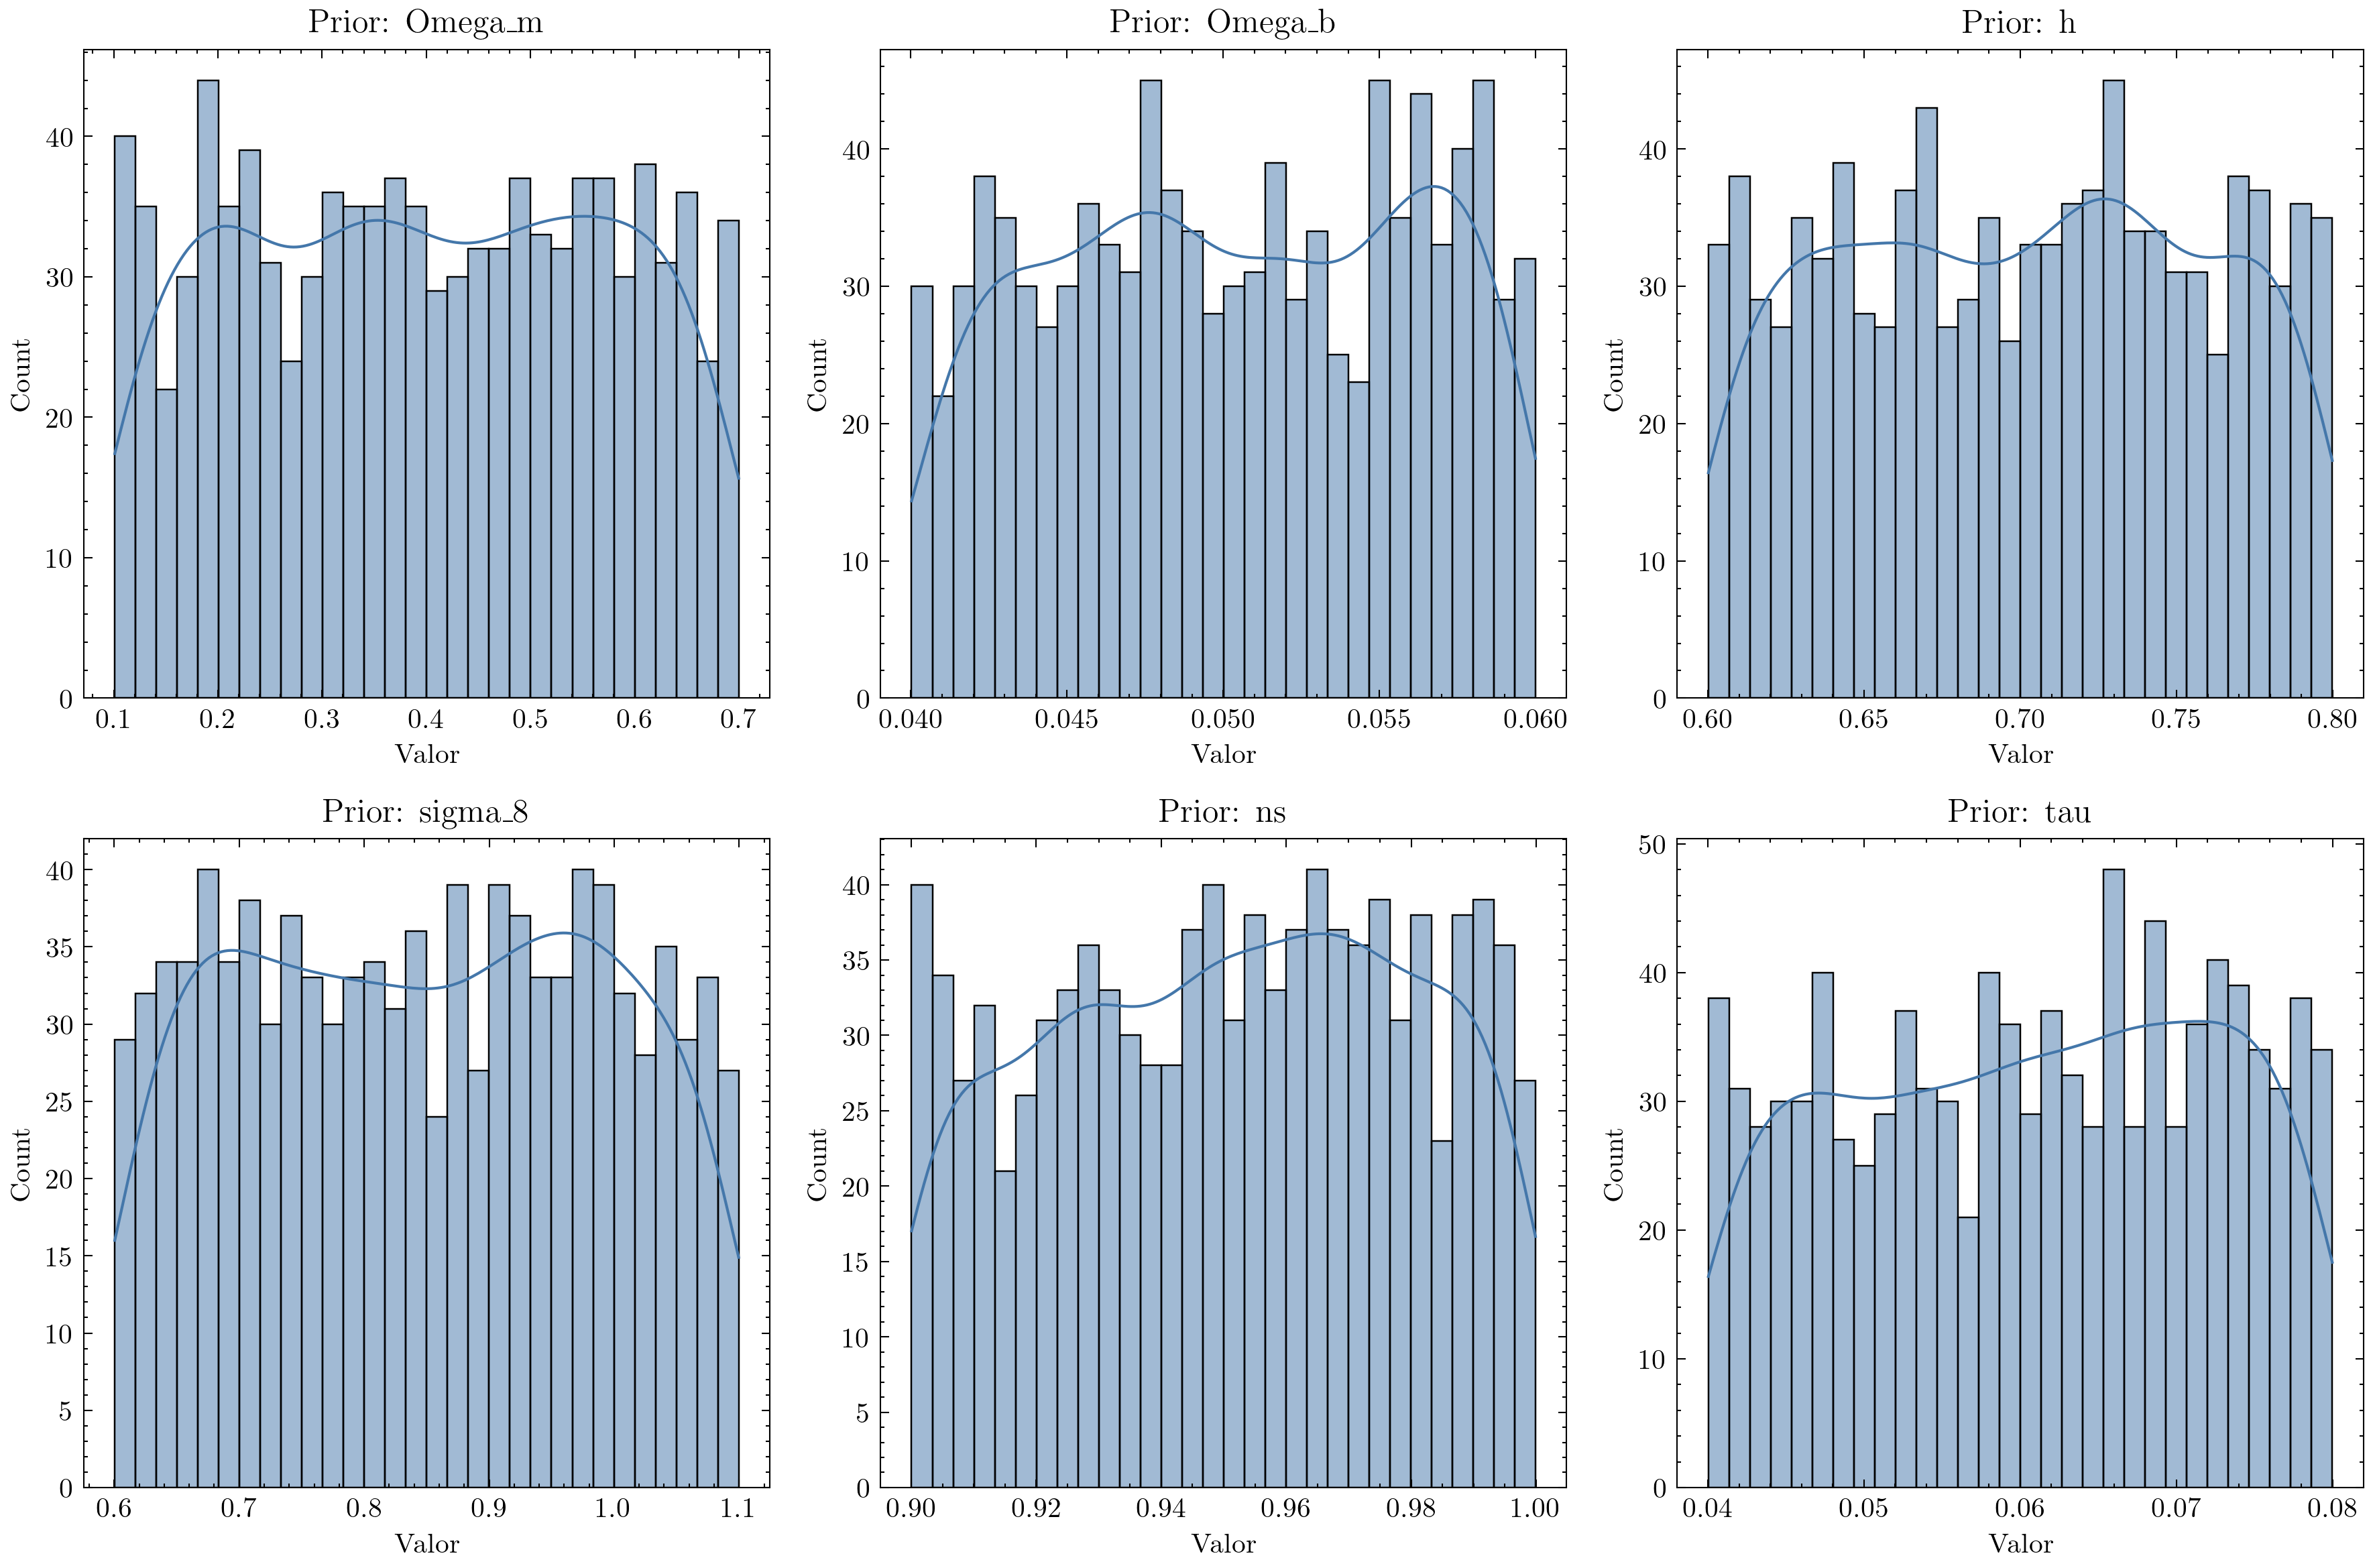

In [6]:
prior_samples = prior.sample((1000,))
param_names = list(PARAM_RANGES.keys())

plt.figure(figsize=(12, 8))
for i, name in enumerate(param_names):
    plt.subplot(2, 3, i+1)
    sns.histplot(prior_samples[:, i].numpy(), bins=30, kde=True)
    plt.title(f"Prior: {name}")
    plt.xlabel("Valor")
plt.tight_layout()
plt.show()

In [7]:
from src.inference.utils import load_data

spectra, params = load_data()
print(f"\n=== Shape de los datos ===")
print(f"Espectros: {spectra.shape}")
print(f"Parámetros: {params.shape}")


=== Shape de los datos ===
Espectros: torch.Size([15000, 2401])
Parámetros: torch.Size([15000, 6])


c:\Users\Julian\Documents\cmb-sbi-inference\src\inference\utils.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectra = torch.load(DATA_PATHS[data_type]["spectra"]).fl

In [8]:
from src.inference.utils import preprocess_spectra

processed_spectra = preprocess_spectra(spectra)
print(f"\nEspectros procesados: {processed_spectra.shape}")


Espectros procesados: torch.Size([15000, 2401])


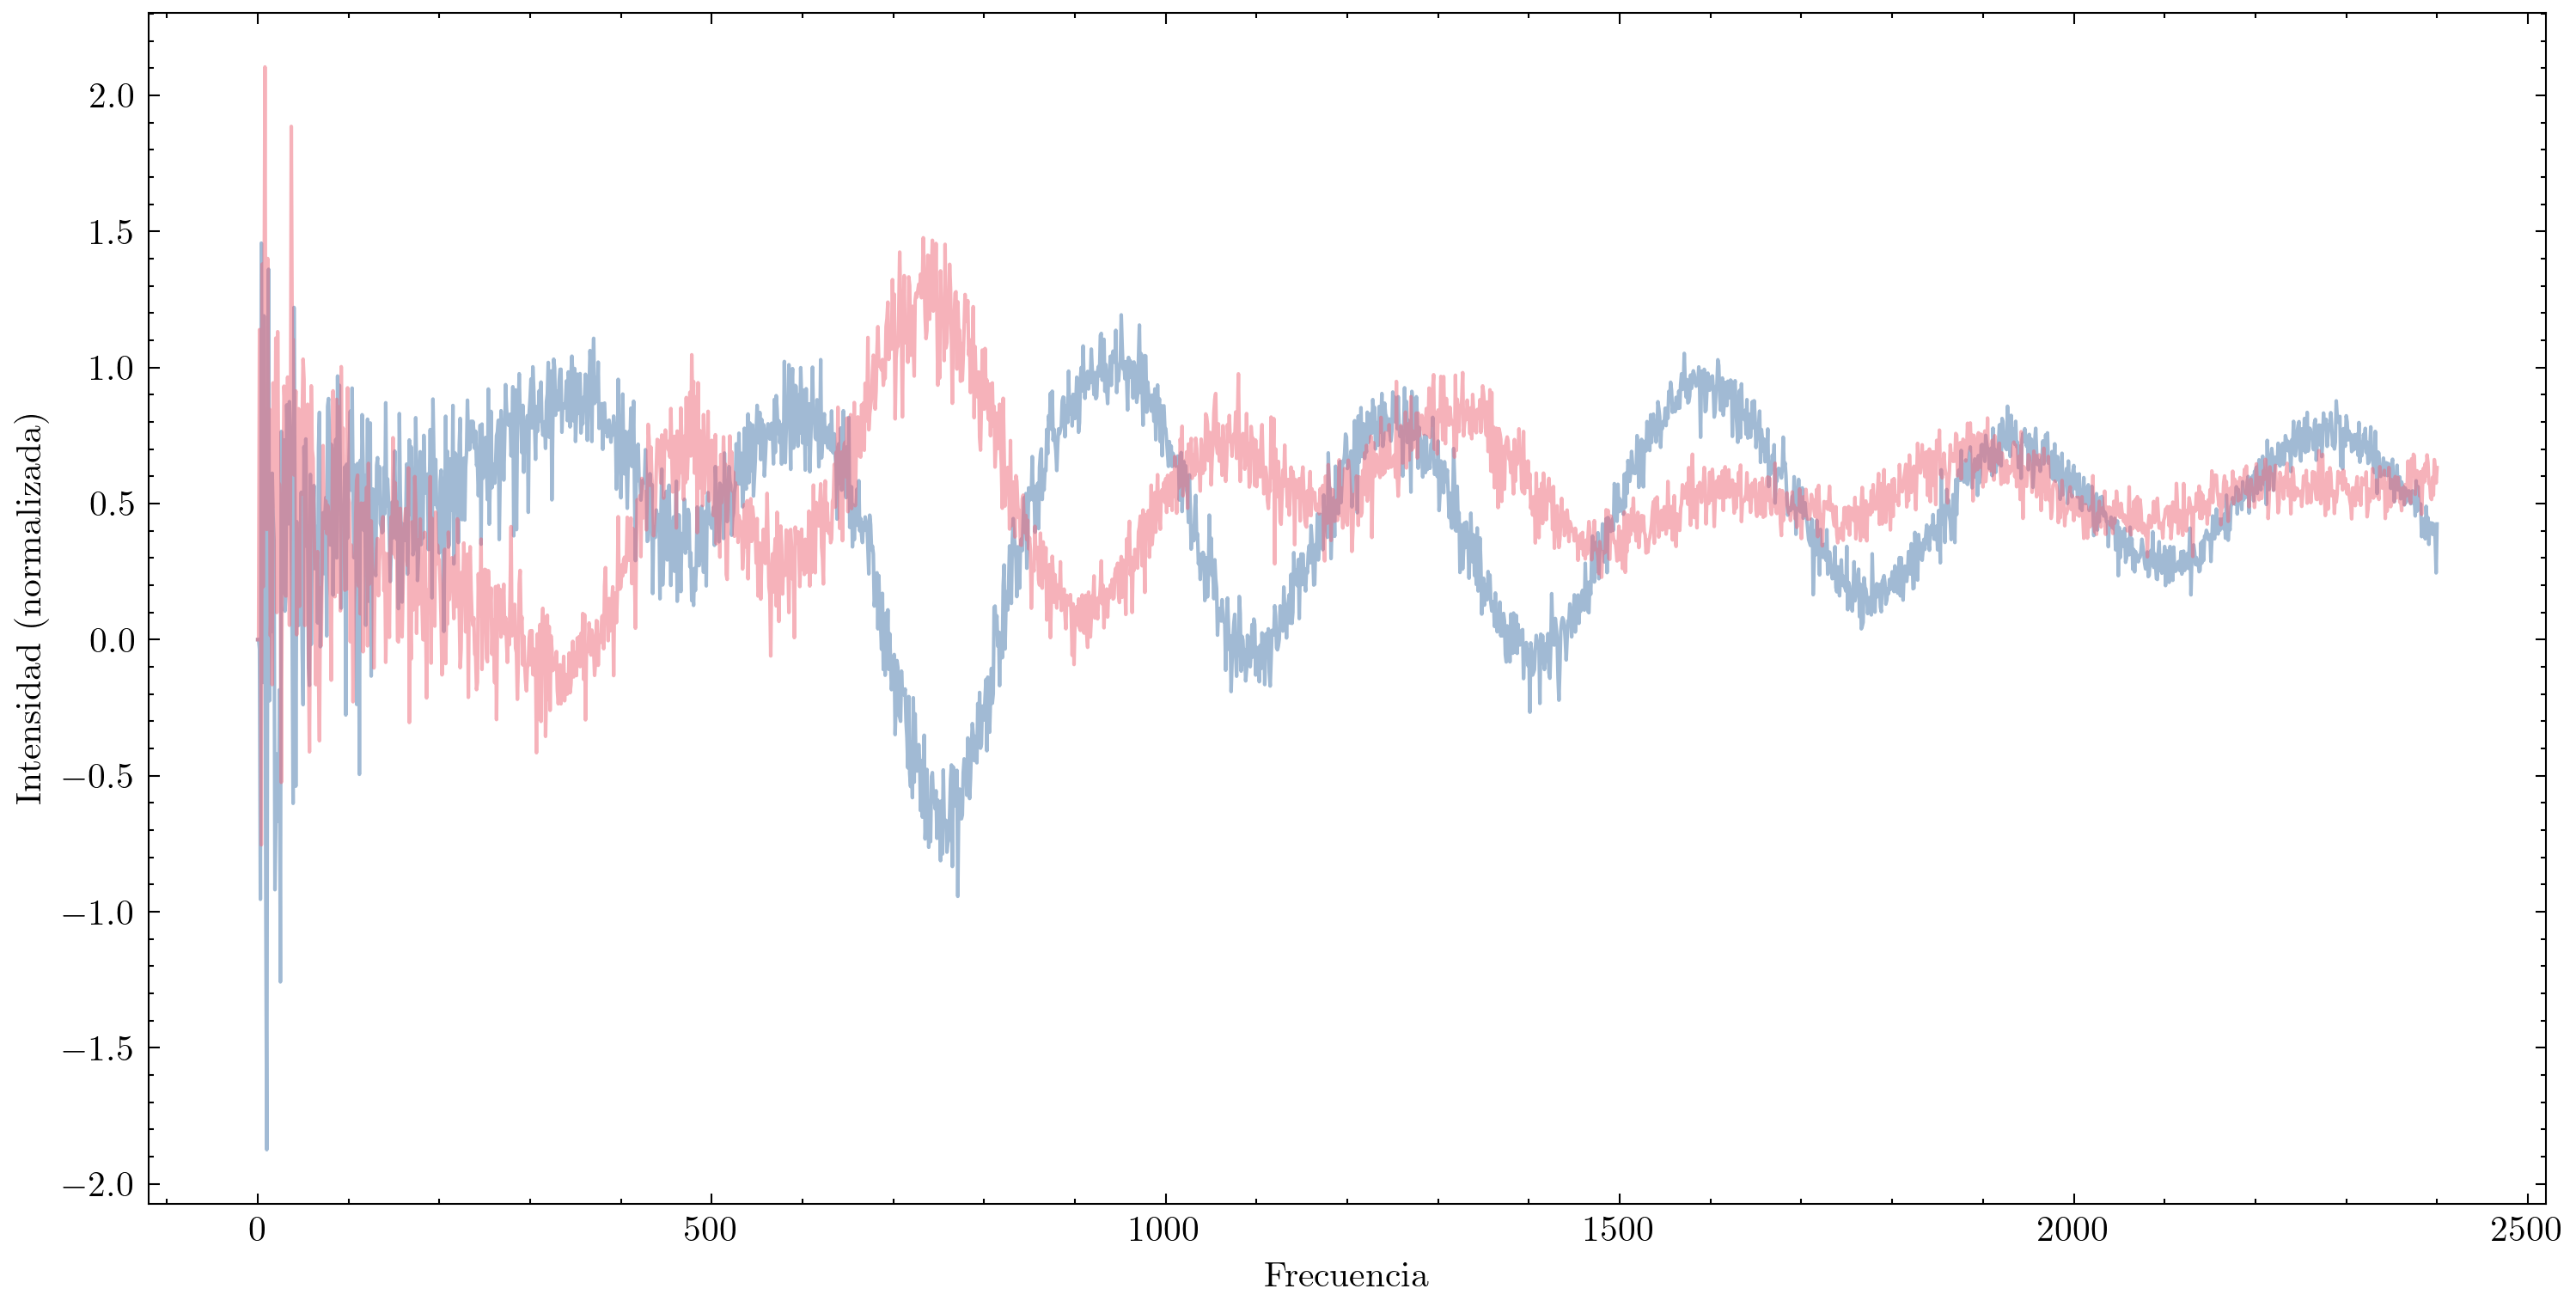

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(processed_spectra[0], alpha=0.5)
plt.plot(processed_spectra[50], alpha=0.5)
plt.xlabel("Frecuencia")
plt.ylabel("Intensidad (normalizada)")
plt.show()

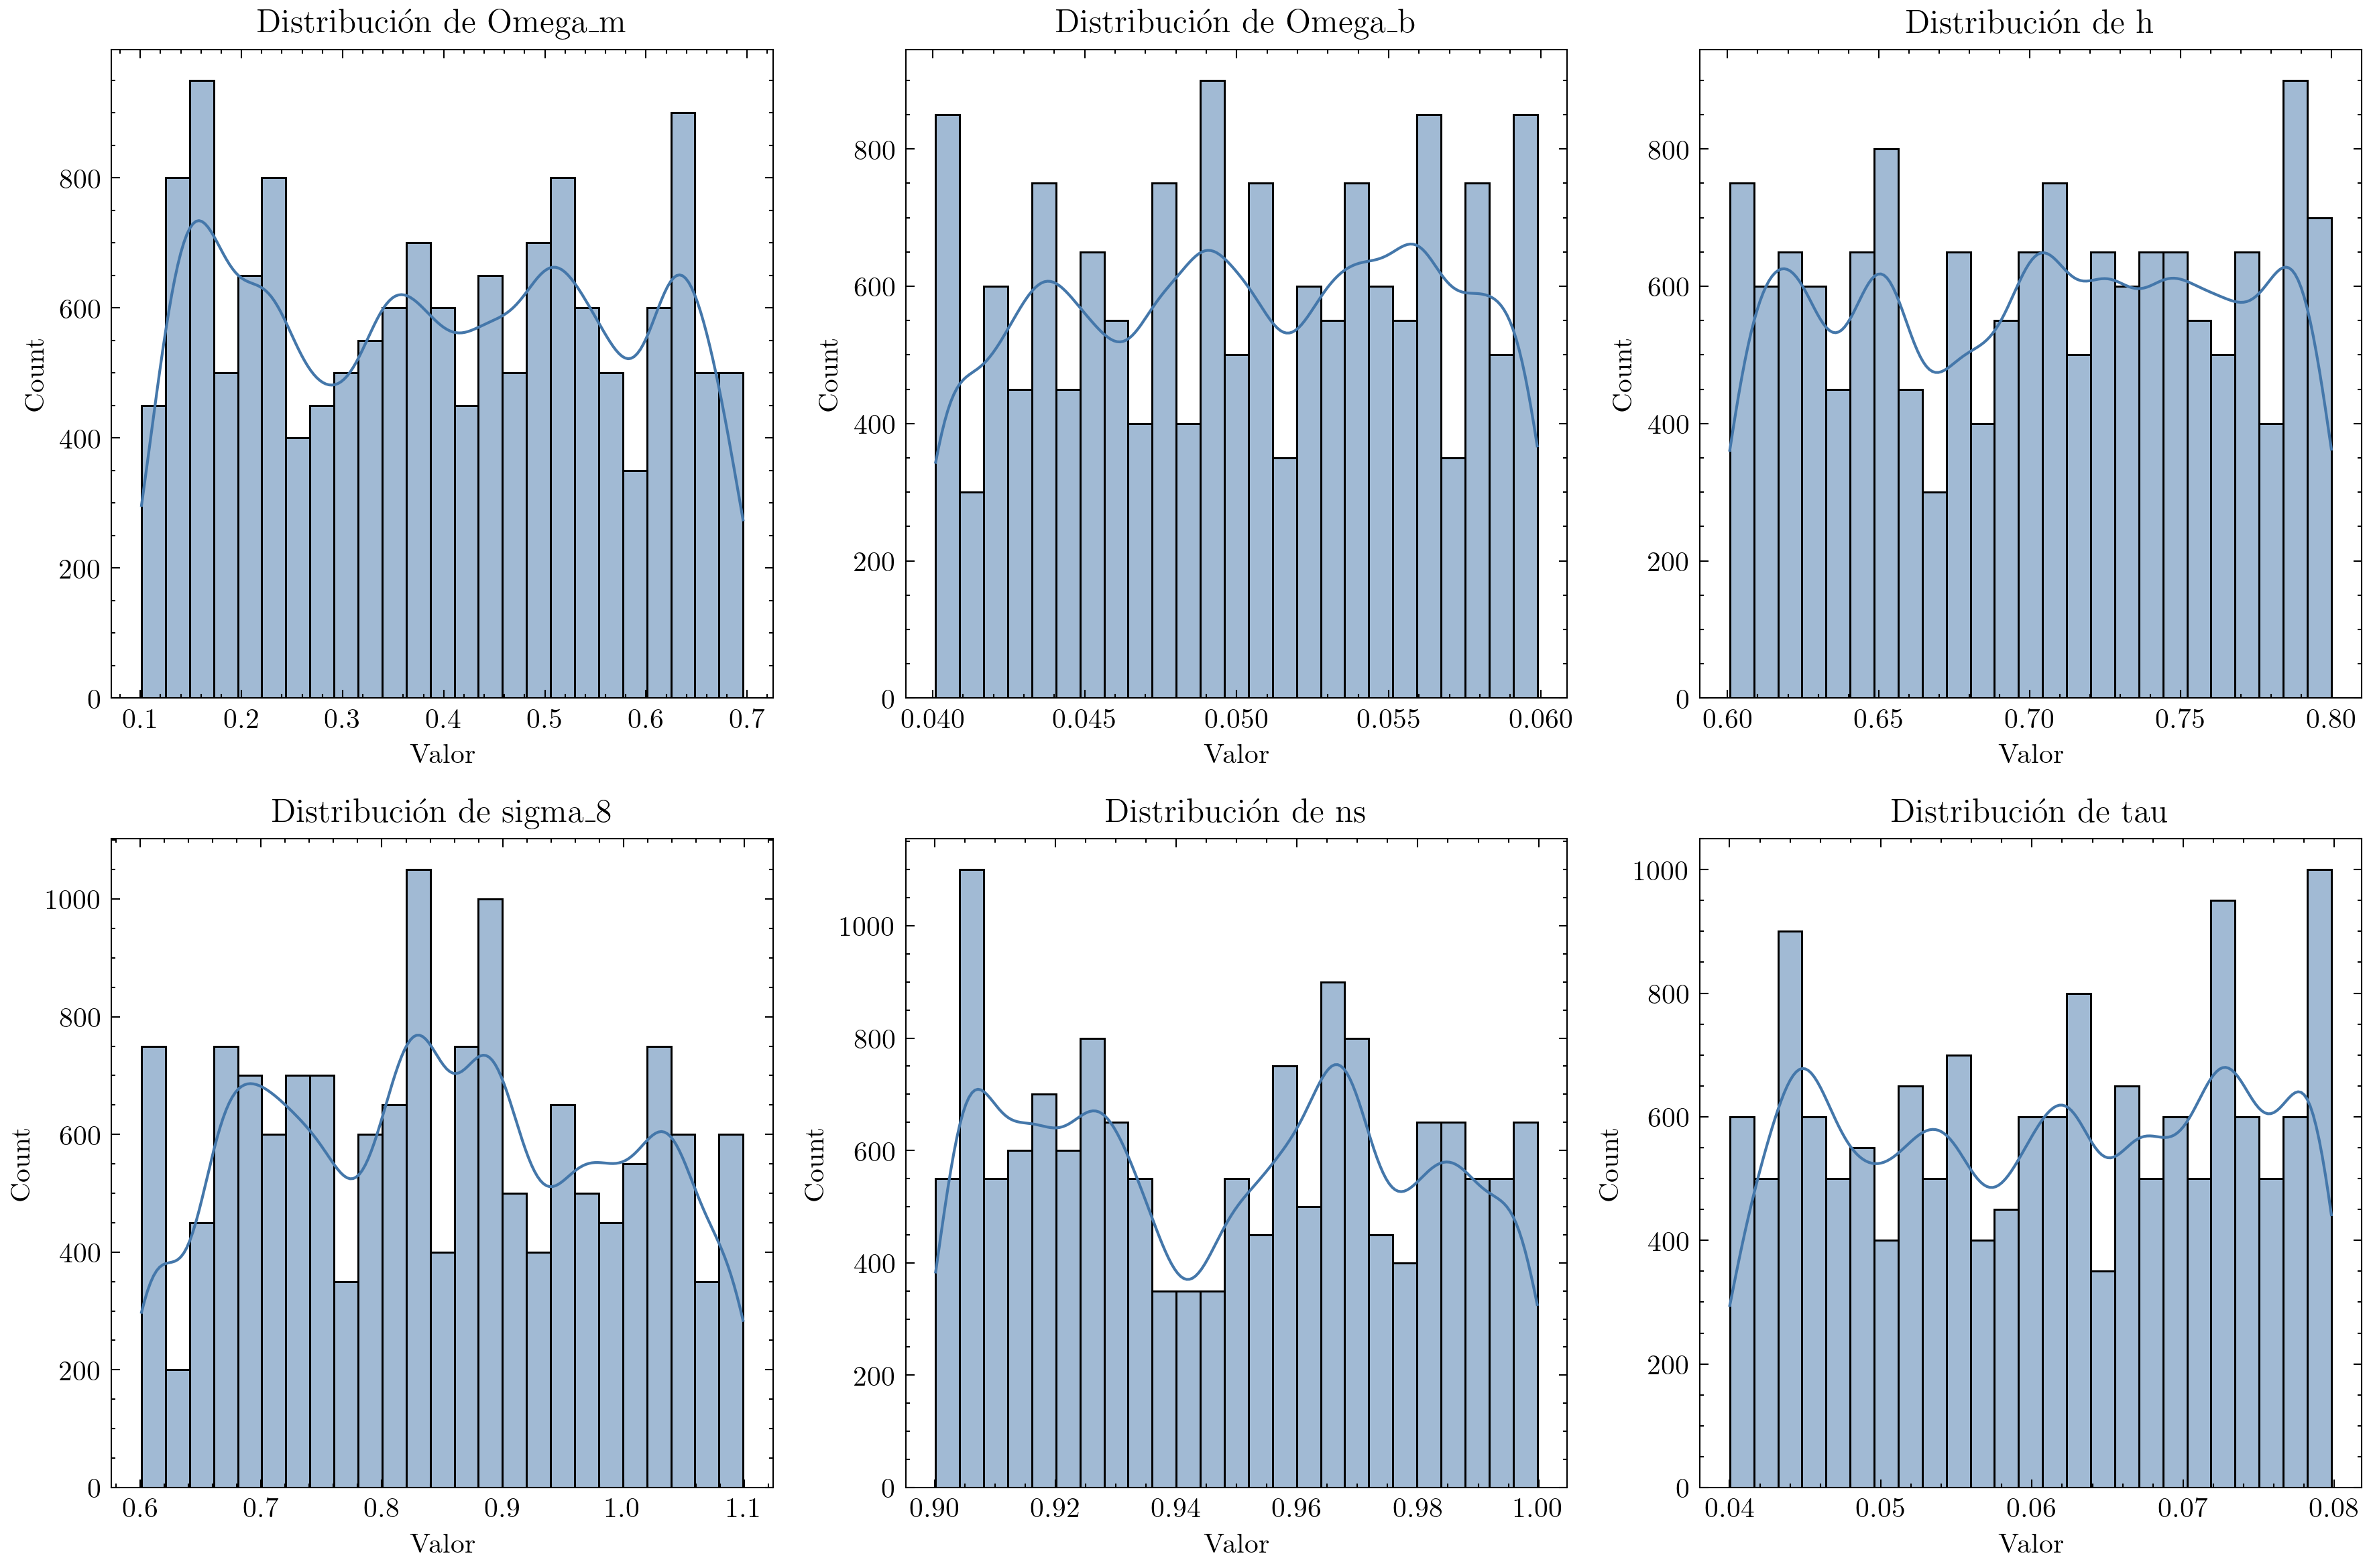

In [10]:
plt.figure(figsize=(12, 8))
for i, name in enumerate(param_names):
    plt.subplot(2, 3, i+1)
    sns.histplot(params[:, i].numpy(), bins=25, kde=True)
    plt.title(f"Distribución de {name}")
    plt.xlabel("Valor")
plt.tight_layout()
plt.show()

In [11]:
def simulator(theta: torch.Tensor) -> torch.Tensor:
    idx = torch.randint(0, len(processed_spectra), (theta.shape[0],))
    return processed_spectra[idx]

test_theta = prior.sample((5,))
simulated_data = simulator(test_theta)

print("\n=== Prueba del Simulador ===")
print(f"Input theta shape: {test_theta.shape}")
print(f"Output spectra shape: {simulated_data.shape}")


=== Prueba del Simulador ===
Input theta shape: torch.Size([5, 6])
Output spectra shape: torch.Size([5, 2401])


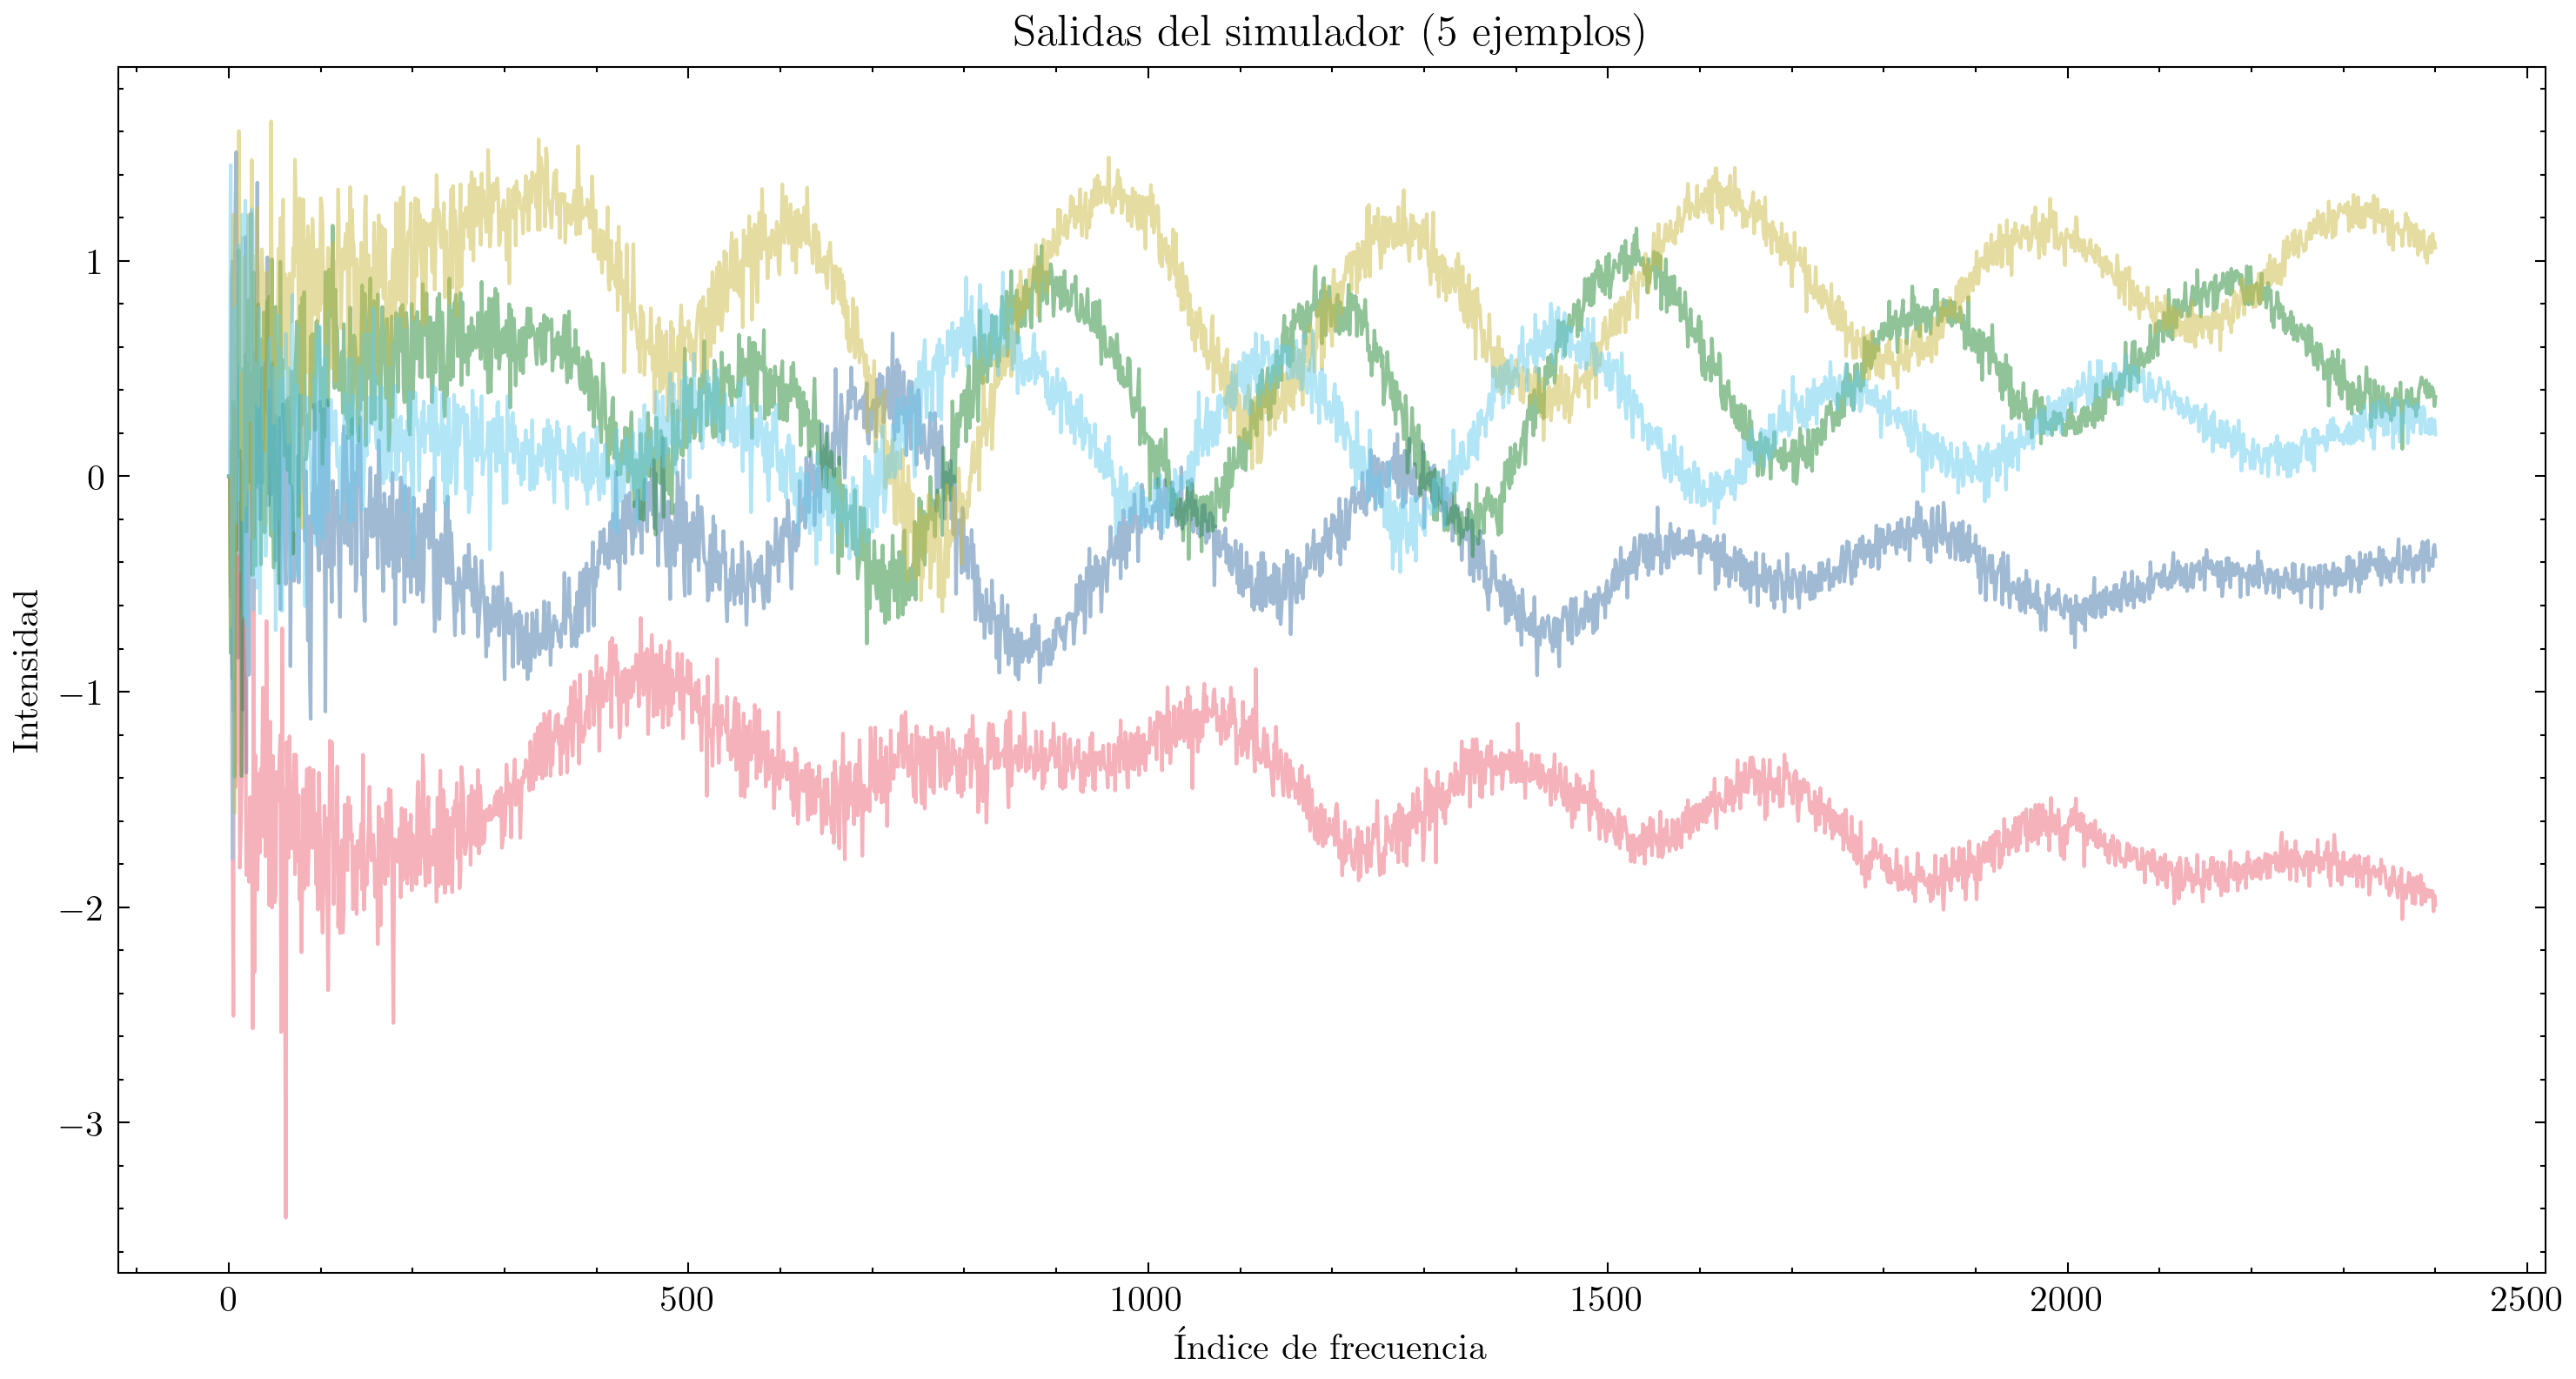

In [12]:
# Verificación de consistencia
plt.figure(figsize=(12, 6))
plt.plot(simulated_data.T, alpha=0.5)
plt.title("Salidas del simulador (5 ejemplos)")
plt.xlabel("Índice de frecuencia")
plt.ylabel("Intensidad")
plt.show()

In [13]:
from sbi.inference import SNPE_C

inference = SNPE_C(
    prior=prior,
    density_estimator=SBI_CONFIG["density_estimator"],
    device=SBI_CONFIG["device"]
)

params_batch = params[1]               
spectra_batch = processed_spectra[1]   

print("\n=== Arquitectura del Modelo ===")
print(inference._build_neural_net(params_batch, spectra_batch))


=== Arquitectura del Modelo ===
NFlowsFlow(
  (net): Flow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): PointwiseAffineTransform()
        (1): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=1, out_features=50, bias=True)
            (context_layer): Linear(in_features=1, out_features=50, bias=True)
            (blocks): ModuleList(
              (0-1): 2 x MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (final_layer): MaskedLinear(in_features=50, out_features=2, bias=True)
          )
        )
        (2): RandomPermutation()
        (3): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=1, out_features=50, bias=True)
            (

c:\Users\Julian\anaconda3\envs\sbi_env\lib\site-packages\sbi\neural_nets\net_builders\flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


In [14]:
from src.inference.utils import load_model, save_model
from src.inference.config import get_prior, SBI_CONFIG
import time

start_time = time.time()
density_estimator = load_model(SBI_CONFIG["model_save_path"])
print(f"Modelo cargado en {time.time() - start_time:.2f} segundos")

Modelo cargado en 0.05 segundos


c:\Users\Julian\Documents\cmb-sbi-inference\src\inference\utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path)


In [15]:
# num_samples = 2000
# num_chains = 4
# observation_idx = 0
# param_names = ['Omega_m', 'Omega_b', 'h', 'sigma_8', 'ns', 'tau']  
# num_test = 200  
# theta_test = prior.sample((num_test,))
# x_test = simulator(theta_test)

# posterior = inference.build_posterior(density_estimator)
# samples = posterior.sample(
#     (num_samples, num_chains),
#     x=x_test[observation_idx:observation_idx+1],  
#     show_progress_bars=True
# )

# samples_flat = samples.reshape(-1, 6)

# fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# for i, (ax, name) in enumerate(zip(axes.flat, param_names)):
#     sns.histplot(samples_flat[:, i], ax=ax, kde=True, stat='density', color=f'C{i}')
#     ax.axvline(theta_test[observation_idx, i], color='r', linestyle='--', label='Valor real')
#     ax.set_title(f'{name}', fontsize=14)
#     ax.legend()
# plt.suptitle('Distribuciones Posteriores para 6 Parámetros', y=1.02, fontsize=16)
# plt.tight_layout()
# plt.show()


Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples: 100834it [00:08, 12013.91it/s]                           


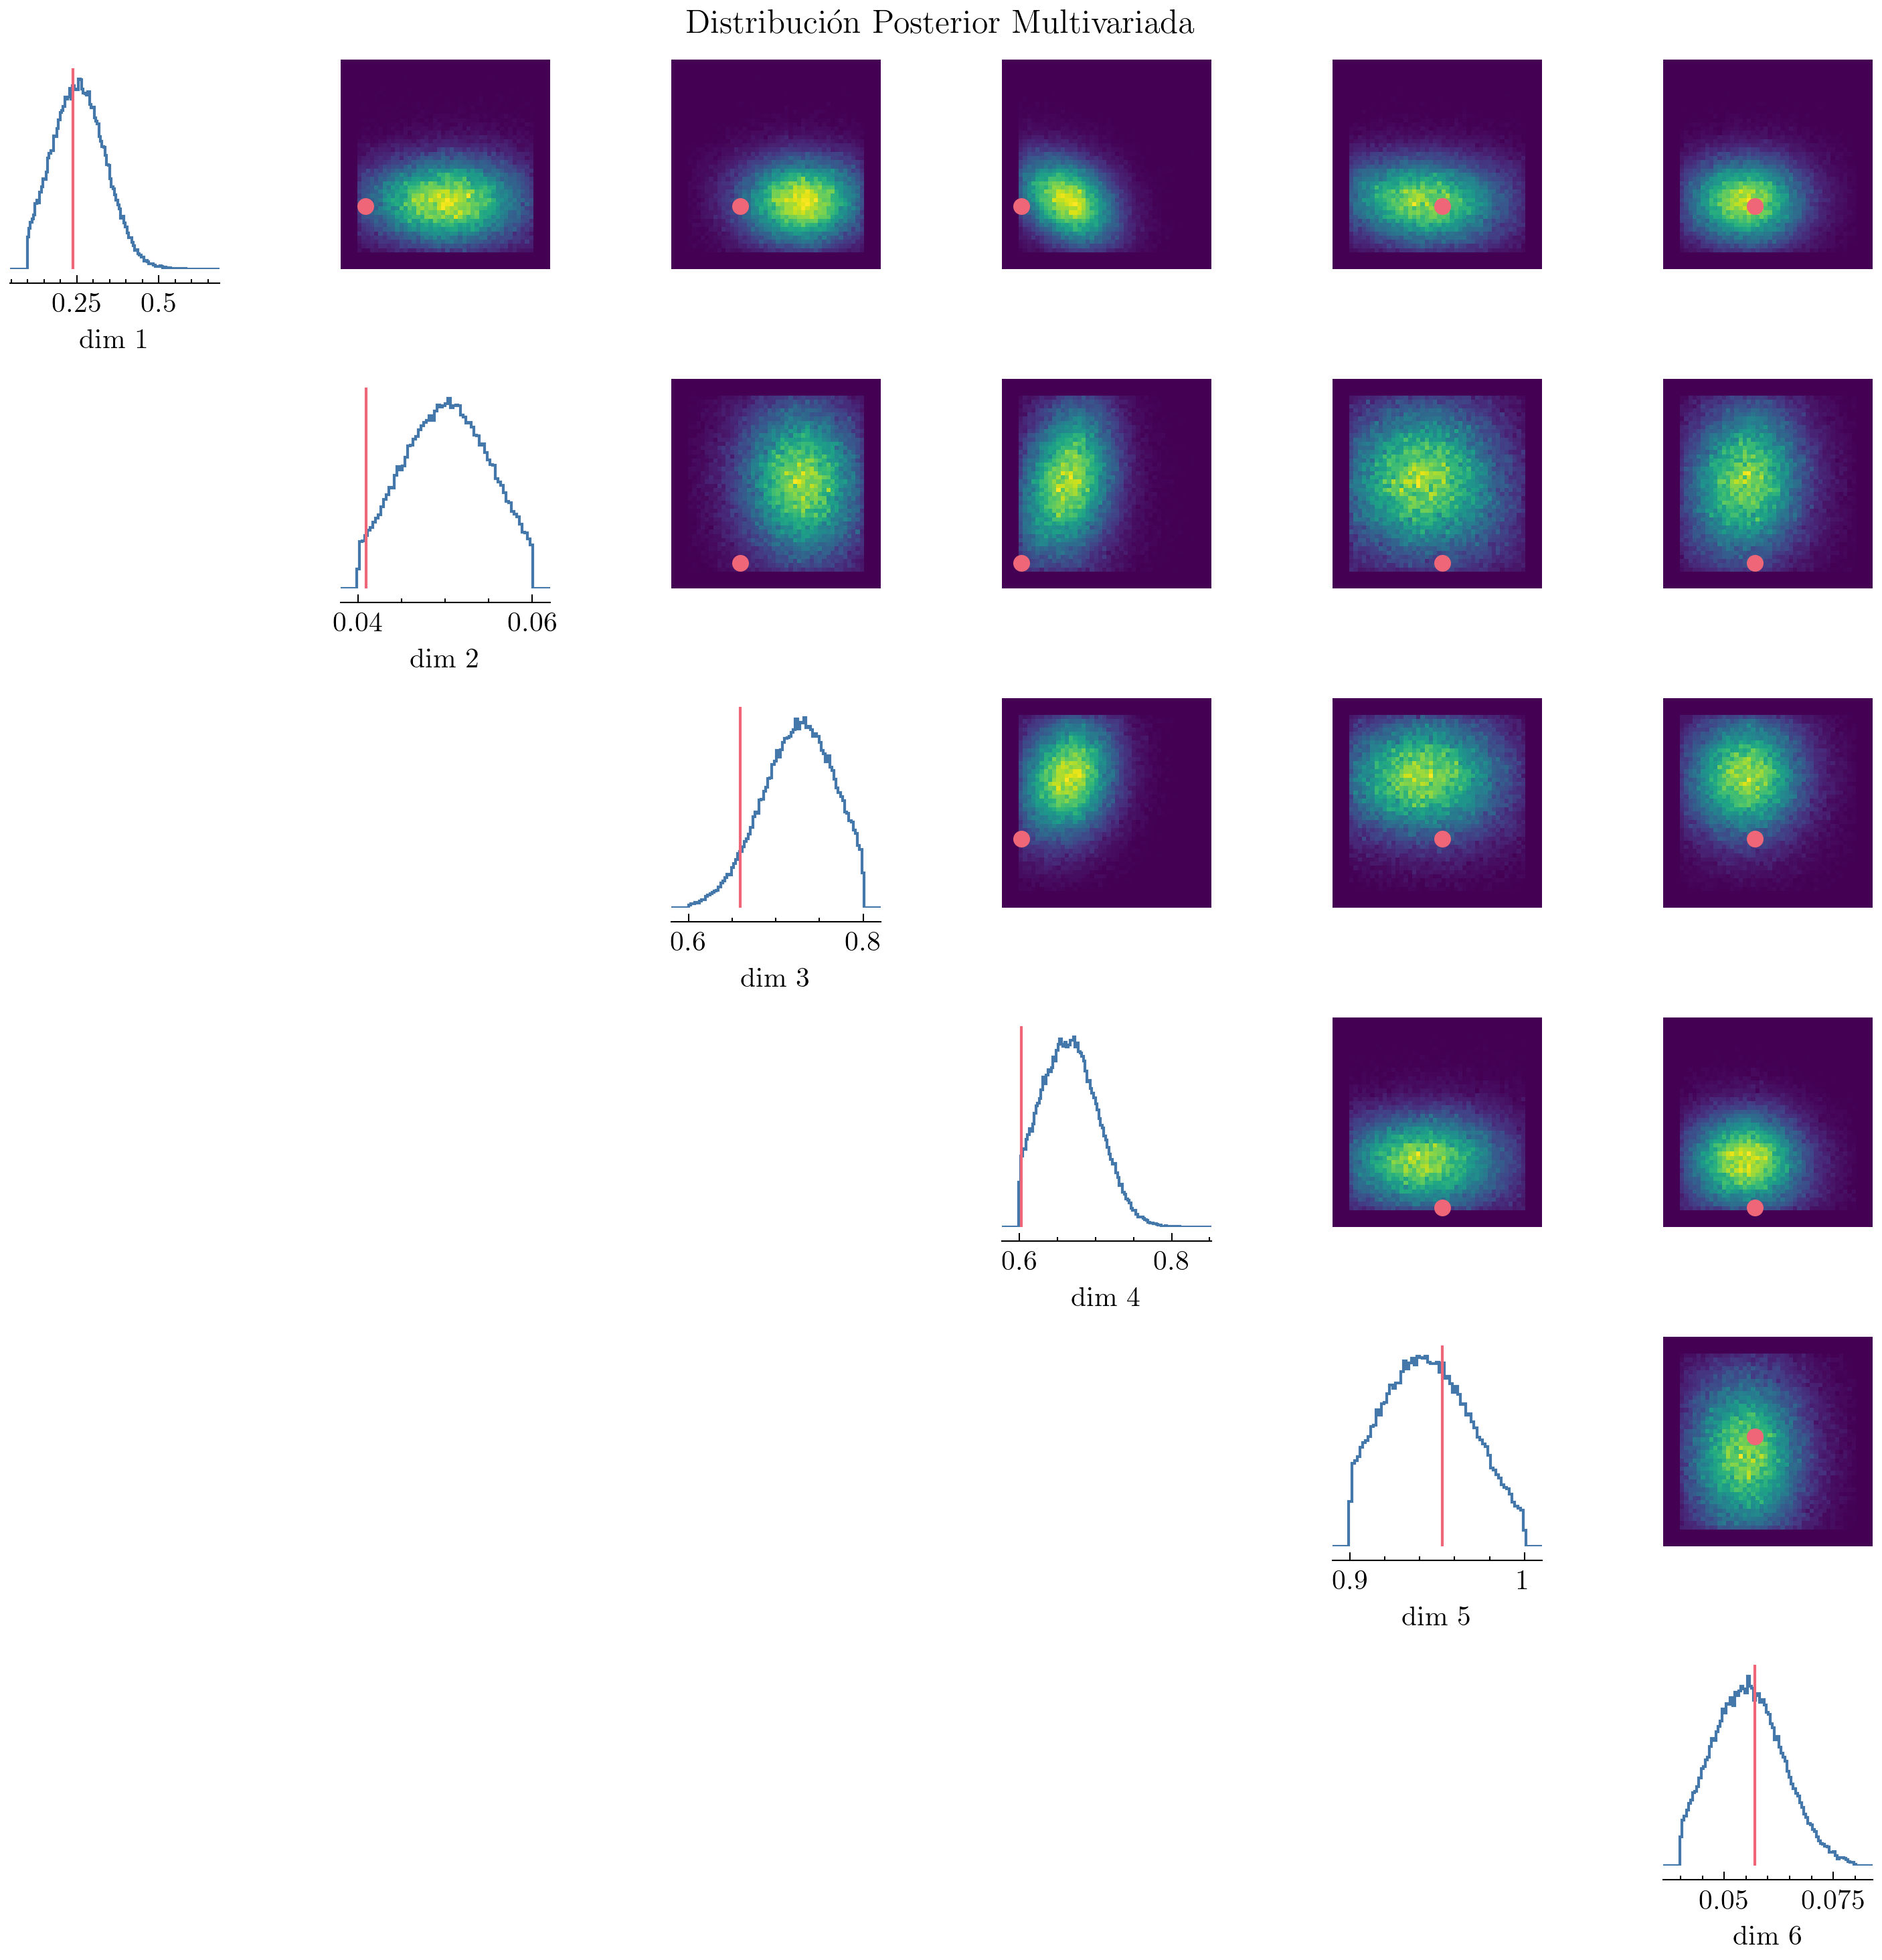

In [ ]:
from sbi.analysis import pairplot

posterior = inference.build_posterior(density_estimator)
theta_true = prior.sample((1,))
x_obs = simulator(theta_true)
samples = posterior.sample((100000,), x=x_obs)

fig = pairplot(
    samples,
    points=theta_true,
    figsize=(10, 10),
)

plt.suptitle('Distribución Posterior Multivariada')
plt.tight_layout()
plt.show()